In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import json
from PIL import Image

In [ ]:
# Input Paths 
HOME = "/content/drive/MyDrive/3CTYOLOv12/VGG(VIA)/"
CSV_PATH = f"{HOME}via_project_26Jul2025_19h12m_csv.csv"
IMAGES_DIR = f"{HOME}images"
OUTPUT_DIR = f"{HOME}labels"
os.makedirs(OUTPUT_DIR, exist_ok=True)


CLASS_NAMES = ["BMW", "mercedes-benz"]

In [ ]:
def parse_via_row(row):
    filename = row["filename"]
    shape_attrs  = json.loads(row["region_shape_attributes"])
    region_attrs = json.loads(row["region_attributes"])

    if shape_attrs.get("name") != "polygon":
        return None  # Only handle polygon

    # Determine class id (first non-empty attribute)
    class_id = None
    for key, val in region_attrs.items():
        if val == "" and key in CLASS_NAMES:
            class_id = CLASS_NAMES.index(key)
            break
    if class_id is None:
        return None

    # Normalize polygon coordinates
    image_path = os.path.join(IMAGES_DIR, filename)
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return None

    with Image.open(image_path) as img:
        w, h = img.size

    all_x = shape_attrs["all_points_x"]
    all_y = shape_attrs["all_points_y"]
    norm_points = []
    for x, y in zip(all_x, all_y):
        norm_x = x / w
        norm_y = y / h
        norm_points.extend([norm_x, norm_y])

    return filename, class_id, norm_points

In [ ]:
def convert_csv_to_yolo(csv_path):
    df = pd.read_csv(csv_path)
    annotations = {}

    for _, row in df.iterrows():
        parsed = parse_via_row(row)
        if parsed is None:
            continue
        filename, class_id, norm_points = parsed
        txt_filename = os.path.splitext(filename)[0] + ".txt"
        line = f"{class_id} " + " ".join([f"{p:.17f}" for p in norm_points])
        annotations.setdefault(txt_filename, []).append(line)

    # Write to output directory
    for txt_file, lines in annotations.items():
        out_path = os.path.join(OUTPUT_DIR, txt_file)
        with open(out_path, "w") as f:
            f.write("\n".join(lines))

In [ ]:
convert_csv_to_yolo(CSV_PATH)
print(" Annotations converted and saved to:", OUTPUT_DIR)

 Annotations converted and saved to: /content/drive/MyDrive/3CTYOLOv12/labels


In [ ]:
def test_single_row(index=0):
    df = pd.read_csv(CSV_PATH)
    parsed = parse_via_row(df.iloc[index])
    if parsed:
        print("Test Output:\n", parsed)
    else:
        print("Failed to parse row")

test_single_row(0)

Test Output:
 ('481069944_607307268764594_8607083815216875903_n.jpg', 0, [0.2905759162303665, 0.17102966841186737, 0.6588132635253054, 0.16055846422338568, 0.7696335078534031, 0.3019197207678883, 0.7853403141361257, 0.2591623036649215, 0.8464223385689355, 0.2661431064572426, 0.8481675392670157, 0.30715532286212915, 0.7853403141361257, 0.3228621291448517, 0.924956369982548, 0.4677137870855148, 0.9301919720767888, 0.7373472949389179, 0.887434554973822, 0.7801047120418848, 0.08551483420593368, 0.81239092495637, 0.053228621291448515, 0.7626527050610821, 0.027050610820244327, 0.5785340314136126, 0.053228621291448515, 0.4607329842931937, 0.18586387434554974, 0.34467713787085513, 0.1143106457242583, 0.3307155322862129, 0.112565445026178, 0.28883071553228623, 0.18586387434554974, 0.2801047120418848, 0.18411867364746945, 0.3158813263525305, 0.2949389179755672, 0.17102966841186737])


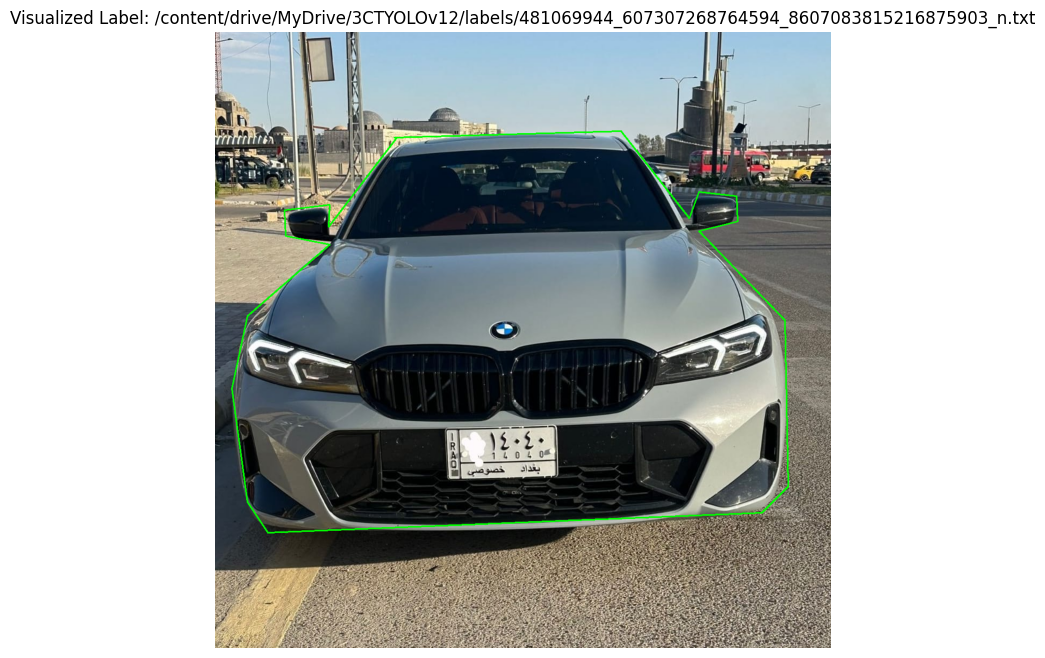

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def visualize_yolo_polygon_label(image_path, label_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Image not found at {image_path}")
        return
    height, width = image.shape[:2]

    with open(label_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        coords = list(map(float, parts[1:]))

        points = np.array([
            [int(x * width), int(y * height)]
            for x, y in zip(coords[::2], coords[1::2])
        ], np.int32)
        points = points.reshape((-1, 1, 2))

        color = (0, 255, 0) if class_id == 0 else (255, 0, 0)
        cv2.polylines(image, [points], isClosed=True, color=color, thickness=2)

    # Convert BGR to RGB for matplotlib display
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Visualized Label: {label_path}")
    plt.show()

# Example usage:
visualize_yolo_polygon_label(
    image_path= f"{HOME}images/481069944_607307268764594_8607083815216875903_n.jpg",
    label_path= f"{HOME}labels/481069944_607307268764594_8607083815216875903_n.txt")

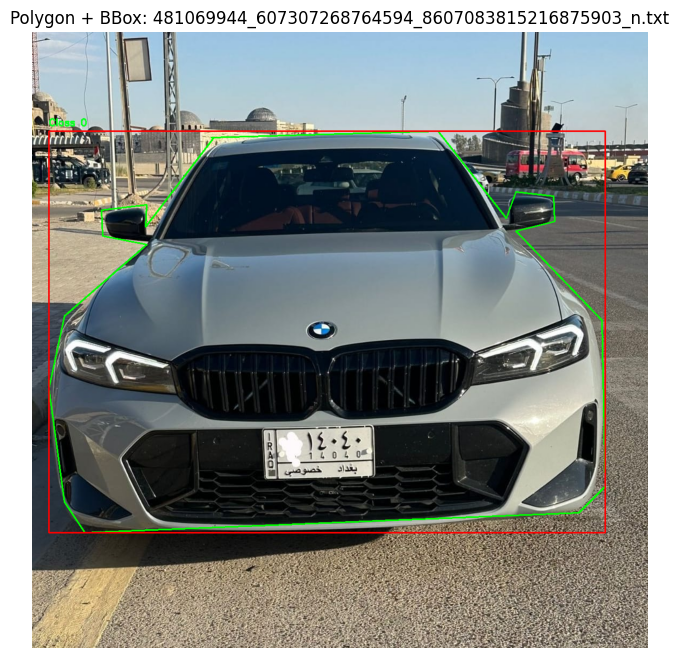

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

def visualize_yolo_polygon_and_bbox(image_path, label_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Image not found at {image_path}")
        return
    height, width = image.shape[:2]

    with open(label_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        coords = list(map(float, parts[1:]))

        # Convert normalized polygon points to absolute pixel coordinates
        points = np.array([
            [int(x * width), int(y * height)]
            for x, y in zip(coords[::2], coords[1::2])
        ], np.int32)

        # Draw the polygon
        cv2.polylines(image, [points.reshape((-1, 1, 2))], isClosed=True, color=(0, 255, 0), thickness=2)

        # Get bounding box from polygon
        x_min = np.min(points[:, 0])
        y_min = np.min(points[:, 1])
        x_max = np.max(points[:, 0])
        y_max = np.max(points[:, 1])

        # Draw the bounding box(red)
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2) 
        # put class id
        cv2.putText(image, f"Class {class_id}", (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (36, 255, 12), 2)

    # Show image
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Polygon + BBox: {os.path.basename(label_path)}")
    plt.show()


# Example test usage
def test_visualization():
    image_path = f"{HOME}images/481069944_607307268764594_8607083815216875903_n.jpg"
    label_path = f"{HOME}labels/481069944_607307268764594_8607083815216875903_n.txt"
    visualize_yolo_polygon_and_bbox(image_path, label_path)

# Run the test
test_visualization()

Current Structure of the Images Annotated with VGG(VIA)
```
images/
    image1.jpg
    image2.jpg
    ...
labels/
    image1.txt
    image2.txt
    ...

```



### Goal: YOLO Dataset Structure


```
YOLO/
├── train/
│   ├── images/
│   └── labels/
├── val/
│   ├── images/
│   └── labels/
└── test/
    ├── images/
    └── labels/
```

Split Logic

Total = All labeled images (those that have a .txt in labels)

Test = 10 samples

Val = 30 samples

Train = rest of samples

In [ ]:
import os
import shutil
import random


HOME = "/content/drive/MyDrive/3CTYOLOv12/VGG(VIA)/"
LABELS_DIR = f"{HOME}labels"
IMAGES_DIR = f"{HOME}images"
YOLO_OUTPUT_DIR = f"{HOME}YOLO_VGG"
TEST_COUNT = 10
VAL_COUNT  = 30

# Get labeled image base names
label_files = [f for f in os.listdir(LABELS_DIR) if f.endswith('.txt')]
image_basenames = [os.path.splitext(f)[0] for f in label_files]

#  Shuffle and split
random.shuffle(image_basenames)
test_set  = image_basenames[:TEST_COUNT]
val_set   = image_basenames[TEST_COUNT:TEST_COUNT + VAL_COUNT]
train_set = image_basenames[TEST_COUNT + VAL_COUNT:]

# Helper to copy files
def copy_files(split_name, basenames):
    for base in basenames:
        img_src = os.path.join(IMAGES_DIR, base + ".jpg")
        label_src = os.path.join(LABELS_DIR, base + ".txt")
        img_dst = os.path.join(YOLO_OUTPUT_DIR, split_name, "images", base + ".jpg")
        label_dst = os.path.join(YOLO_OUTPUT_DIR, split_name, "labels", base + ".txt")

        if os.path.exists(img_src) and os.path.exists(label_src):
            os.makedirs(os.path.dirname(img_dst), exist_ok=True)
            os.makedirs(os.path.dirname(label_dst), exist_ok=True)
            shutil.copyfile(img_src, img_dst)
            shutil.copyfile(label_src, label_dst)

# Copy to YOLO format
copy_files("train", train_set)
copy_files("val", val_set)
copy_files("test", test_set)

print(f"Dataset prepared: {len(train_set)} train, {len(val_set)} val, {len(test_set)} test.")

Dataset prepared: 194 train, 30 val, 10 test.


# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.


Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [3]:
import os
from google.colab import userdata

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [4]:
!nvidia-smi

Tue Jul 29 18:09:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   58C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [6]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.


100%|██████████| 51.4M/51.4M [00:00<00:00, 82.2MB/s]


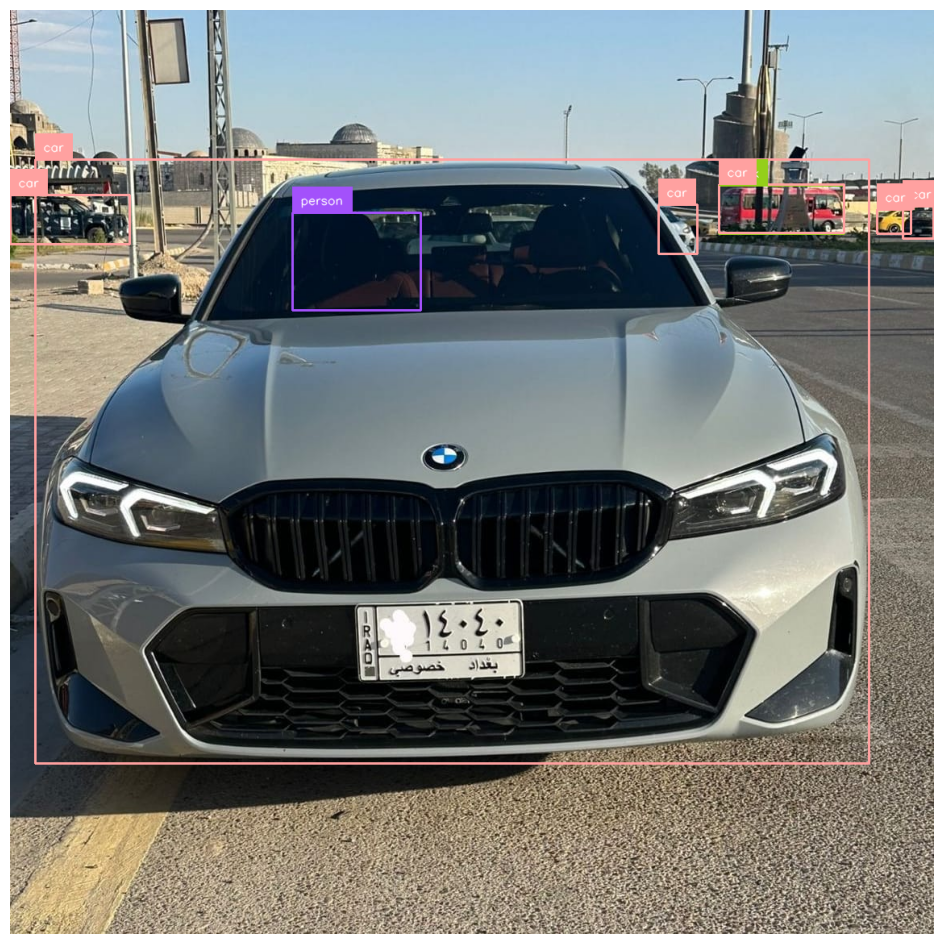

In [7]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = "/content/drive/MyDrive/3CTYOLOv12/VGG(VIA)/images/481069944_607307268764594_8607083815216875903_n.jpg"
image = cv2.imread(image_path)

model = YOLO('yolov12l.pt')

results    = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator   = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## We use our custm dataset from Google Drive

In [8]:
# instead here we use from drive
dataset_location = "/content/drive/MyDrive/3CTYOLOv12/VGG(VIA)/YOLO_VGG"

# Create data.yaml

In [9]:
# New: Replace Roboflow dataset with local dataset
dataset_location = "/content/drive/MyDrive/3CTYOLOv12/VGG(VIA)/YOLO_VGG"

data_yaml_path = f"{dataset_location}/data.yaml"

class_names = ["BMW", "mercedes-benz"]

with open(data_yaml_path, "w") as f:
    f.write(f"path: {dataset_location}\n")
    f.write("train: train/images\n")
    f.write("val: val/images\n")
    f.write("test: test/images\n")
    f.write(f"names: {class_names}\n")
    f.write(f"nc: {len(class_names)}\n")

**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [20]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(
                    data=f"{data_yaml_path}",
                    epochs=100)

New https://pypi.org/project/ultralytics/8.3.170 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/drive/MyDrive/3CTYOLOv12/VGG(VIA)/YOLO_VGG/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=Fal

100%|██████████| 755k/755k [00:00<00:00, 21.4MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2, 1, 2]          
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2, 1, 4]        
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    677120  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.26M/5.26M [00:00<00:00, 106MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/3CTYOLOv12/VGG(VIA)/YOLO_VGG/train/labels... 194 images, 0 backgrounds, 0 corrupt: 100%|██████████| 194/194 [01:22<00:00,  2.35it/s]

train: New cache created: /content/drive/MyDrive/3CTYOLOv12/VGG(VIA)/YOLO_VGG/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/3CTYOLOv12/VGG(VIA)/YOLO_VGG/val/labels... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:40<00:00,  1.36s/it]

val: New cache created: /content/drive/MyDrive/3CTYOLOv12/VGG(VIA)/YOLO_VGG/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      6.81G      3.263      4.105      4.349          4        640: 100%|██████████| 13/13 [00:44<00:00,  3.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.90s/it]

                   all         30         37    0.00892      0.514     0.0102    0.00277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100       6.9G       3.15      3.982      4.214          4        640: 100%|██████████| 13/13 [00:20<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all         30         37    0.00892      0.514    0.00901    0.00316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.93G       3.16      3.938      4.152          2        640: 100%|██████████| 13/13 [00:29<00:00,  2.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]

                   all         30         37    0.00796      0.486    0.00938    0.00286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       6.9G      2.928      3.729      4.046          3        640: 100%|██████████| 13/13 [00:23<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

                   all         30         37    0.00868      0.514    0.00801     0.0024



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.77G      2.957      3.551      3.893          4        640: 100%|██████████| 13/13 [00:22<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all         30         37    0.00886      0.514    0.00875    0.00238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.93G      3.032      3.371      3.794          4        640: 100%|██████████| 13/13 [00:23<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

                   all         30         37    0.00745      0.432     0.0147    0.00226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.92G      2.863      3.371       3.61          7        640: 100%|██████████| 13/13 [00:20<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all         30         37    0.00163      0.162    0.00194   0.000385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.93G      2.769      3.266       3.45          6        640: 100%|██████████| 13/13 [00:19<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         30         37    0.00989      0.405     0.0129    0.00267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100       6.9G      2.715      3.109      3.347          4        640: 100%|██████████| 13/13 [00:24<00:00,  1.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         30         37     0.0115      0.676      0.025    0.00895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.77G      2.748      3.064      3.318          3        640: 100%|██████████| 13/13 [00:20<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all         30         37      0.285      0.324      0.234     0.0675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.93G      2.694      3.003      3.247          8        640: 100%|██████████| 13/13 [00:23<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         30         37     0.0983      0.324     0.0611     0.0169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.93G      2.698      2.951      3.176          5        640: 100%|██████████| 13/13 [00:19<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all         30         37     0.0114      0.622     0.0126    0.00304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100       6.9G      2.581      2.844      3.154          3        640: 100%|██████████| 13/13 [00:21<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

                   all         30         37    0.00603      0.432    0.00681    0.00129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.77G      2.564      2.831      3.104          6        640: 100%|██████████| 13/13 [00:20<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         30         37     0.0674      0.108     0.0587     0.0113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      6.93G       2.53      2.702       3.07          8        640: 100%|██████████| 13/13 [00:22<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all         30         37     0.0336      0.162     0.0194     0.0049



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.93G      2.496      2.627      3.004          4        640: 100%|██████████| 13/13 [00:22<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

                   all         30         37      0.148      0.197     0.0852     0.0161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      6.73G      2.468      2.546      2.968          8        640: 100%|██████████| 13/13 [00:19<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all         30         37     0.0574      0.219     0.0315    0.00731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.94G      2.451      2.565       2.95          8        640: 100%|██████████| 13/13 [00:19<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all         30         37      0.312      0.135      0.102     0.0267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.93G      2.411      2.512      2.912          6        640: 100%|██████████| 13/13 [00:18<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

                   all         30         37      0.155       0.27      0.107      0.036



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      6.93G      2.392      2.412      2.909          8        640: 100%|██████████| 13/13 [00:18<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all         30         37      0.168       0.27      0.125     0.0279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100       6.9G      2.453      2.437      2.912          5        640: 100%|██████████| 13/13 [00:17<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all         30         37      0.223      0.324      0.188      0.071



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.78G      2.298      2.357      2.841          5        640: 100%|██████████| 13/13 [00:19<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]

                   all         30         37      0.335      0.459      0.293      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.94G      2.322       2.43      2.885          4        640: 100%|██████████| 13/13 [00:20<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all         30         37      0.339      0.378      0.433      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      6.93G        2.2      2.241      2.754          8        640: 100%|██████████| 13/13 [00:24<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all         30         37       0.23      0.622      0.242     0.0879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      6.73G      2.309      2.314       2.78          5        640: 100%|██████████| 13/13 [00:19<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all         30         37      0.546      0.595      0.493      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.77G      2.148      2.192      2.758          6        640: 100%|██████████| 13/13 [00:17<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

                   all         30         37       0.53       0.58        0.5      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      6.93G      2.222      2.212      2.784          5        640: 100%|██████████| 13/13 [00:20<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all         30         37      0.472      0.622      0.479      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      6.77G      2.236      2.146      2.745          8        640: 100%|██████████| 13/13 [00:22<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all         30         37      0.508      0.514      0.527      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.73G      2.103      2.142      2.684          5        640: 100%|██████████| 13/13 [00:17<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all         30         37      0.569      0.405      0.486      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.77G      2.203      2.154      2.743          8        640: 100%|██████████| 13/13 [00:18<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         30         37      0.391       0.59      0.437      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.93G      2.059      2.124      2.677          3        640: 100%|██████████| 13/13 [00:17<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

                   all         30         37      0.401      0.542      0.427      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.77G      2.041          2      2.662          4        640: 100%|██████████| 13/13 [00:22<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         30         37      0.671      0.622      0.656      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100       6.9G      2.094      2.106      2.689          5        640: 100%|██████████| 13/13 [00:23<00:00,  1.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

                   all         30         37       0.75      0.595      0.701      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.78G      2.096      1.984      2.659          6        640: 100%|██████████| 13/13 [00:22<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all         30         37      0.552      0.622      0.598      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.93G      1.945      1.929      2.547          4        640: 100%|██████████| 13/13 [00:19<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         30         37      0.633      0.703       0.71      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      6.94G      1.937      1.879      2.568          6        640: 100%|██████████| 13/13 [00:23<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all         30         37       0.78      0.622      0.699      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100       6.9G       1.95      1.846      2.584          6        640: 100%|██████████| 13/13 [00:19<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all         30         37      0.556      0.644      0.635       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.78G      1.903      1.858      2.529          8        640: 100%|██████████| 13/13 [00:18<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         30         37      0.689      0.703      0.676      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      6.94G      1.868      1.807      2.492          7        640: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

                   all         30         37      0.671      0.595      0.701      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.93G      1.888      1.742      2.495          9        640: 100%|██████████| 13/13 [00:21<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all         30         37      0.754       0.58      0.742      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.73G      1.797      1.802      2.462          6        640: 100%|██████████| 13/13 [00:18<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all         30         37      0.676      0.676      0.719      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.77G      1.817      1.738      2.482          6        640: 100%|██████████| 13/13 [00:21<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         30         37      0.698       0.75      0.767      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.94G      1.838      1.687      2.514          9        640: 100%|██████████| 13/13 [00:21<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         30         37      0.775      0.703      0.793       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.93G      1.762      1.667       2.42          8        640: 100%|██████████| 13/13 [00:20<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all         30         37      0.792      0.514      0.729      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100       6.9G      1.744      1.604      2.389          7        640: 100%|██████████| 13/13 [00:21<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all         30         37      0.587      0.703      0.702      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      6.93G      1.838      1.653      2.472          7        640: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all         30         37      0.813      0.514      0.658      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.94G      1.707      1.562      2.368          4        640: 100%|██████████| 13/13 [00:18<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]

                   all         30         37      0.628      0.703      0.693      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      6.94G      1.714      1.607      2.406          5        640: 100%|██████████| 13/13 [00:21<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

                   all         30         37      0.789      0.541      0.712      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       6.9G      1.652      1.557      2.303          5        640: 100%|██████████| 13/13 [00:19<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         30         37      0.851      0.676      0.796      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.77G      1.681      1.515      2.341          8        640: 100%|██████████| 13/13 [00:18<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

                   all         30         37      0.837      0.676       0.79      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      6.93G      1.615      1.568      2.328          5        640: 100%|██████████| 13/13 [00:21<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all         30         37      0.831      0.676      0.775      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.93G      1.607      1.508      2.325          5        640: 100%|██████████| 13/13 [00:21<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all         30         37      0.809      0.757      0.847      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.73G      1.562      1.475      2.219          5        640: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all         30         37      0.831      0.703      0.818      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.94G       1.57      1.468       2.22          7        640: 100%|██████████| 13/13 [00:21<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         30         37      0.788      0.757      0.799      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.93G      1.707      1.571      2.338          4        640: 100%|██████████| 13/13 [00:20<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         30         37      0.851      0.771      0.823      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.93G      1.649      1.466      2.221          7        640: 100%|██████████| 13/13 [00:19<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all         30         37      0.803      0.771      0.836      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100       6.9G      1.529      1.456      2.219          6        640: 100%|██████████| 13/13 [00:20<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all         30         37      0.788       0.73      0.818      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      6.77G      1.574       1.38      2.264          7        640: 100%|██████████| 13/13 [00:21<00:00,  1.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

                   all         30         37       0.71      0.728      0.793      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.93G      1.533      1.394      2.199          4        640: 100%|██████████| 13/13 [00:18<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         30         37      0.868      0.708      0.855      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      6.77G      1.543      1.337      2.236          7        640: 100%|██████████| 13/13 [00:20<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all         30         37      0.711      0.864      0.793      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100       6.9G      1.545       1.36      2.177          6        640: 100%|██████████| 13/13 [00:20<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all         30         37      0.764      0.789      0.835      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      6.77G      1.534      1.402      2.206          4        640: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all         30         37      0.781      0.811      0.817      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      6.94G      1.469      1.317      2.155          9        640: 100%|██████████| 13/13 [00:19<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all         30         37      0.817      0.725      0.811      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      6.77G      1.539      1.366      2.189          5        640: 100%|██████████| 13/13 [00:21<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

                   all         30         37      0.783      0.682      0.789       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100       6.9G      1.466      1.349      2.103          8        640: 100%|██████████| 13/13 [00:18<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all         30         37      0.915      0.649      0.816      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.77G      1.464      1.303      2.114          6        640: 100%|██████████| 13/13 [00:20<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all         30         37      0.749      0.784      0.834      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.93G      1.484      1.357      2.175          3        640: 100%|██████████| 13/13 [00:22<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

                   all         30         37      0.849      0.703      0.828      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.93G      1.465      1.352      2.119          4        640: 100%|██████████| 13/13 [00:18<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

                   all         30         37      0.911       0.73      0.849      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.73G      1.357      1.188       2.06          7        640: 100%|██████████| 13/13 [00:20<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         30         37      0.875      0.649      0.824      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.77G       1.36       1.29      2.054          3        640: 100%|██████████| 13/13 [00:21<00:00,  1.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all         30         37      0.771      0.784      0.851      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.94G      1.432      1.314      2.089          8        640: 100%|██████████| 13/13 [00:18<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

                   all         30         37      0.863      0.676      0.837      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.77G      1.363      1.229      2.062          8        640: 100%|██████████| 13/13 [00:18<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all         30         37      0.732       0.74      0.854      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100       6.9G      1.353      1.177      2.024          6        640: 100%|██████████| 13/13 [00:19<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         30         37      0.768      0.811      0.848      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.78G      1.512      1.335      2.102          7        640: 100%|██████████| 13/13 [00:19<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         30         37      0.801      0.811      0.841      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      6.93G      1.355      1.221      2.052          4        640: 100%|██████████| 13/13 [00:19<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

                   all         30         37      0.801       0.76      0.838      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      6.94G      1.329      1.195       1.98          6        640: 100%|██████████| 13/13 [00:21<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

                   all         30         37      0.827      0.773      0.832      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100       6.9G      1.279      1.129      1.955          6        640: 100%|██████████| 13/13 [00:18<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

                   all         30         37      0.817      0.844      0.881      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.77G      1.285      1.113      1.938          5        640: 100%|██████████| 13/13 [00:18<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

                   all         30         37      0.881      0.811      0.873      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.94G      1.298      1.192      1.949          7        640: 100%|██████████| 13/13 [00:18<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all         30         37      0.799      0.811       0.87      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      6.94G       1.28      1.146      1.924          8        640: 100%|██████████| 13/13 [00:18<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all         30         37      0.894      0.757       0.86      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100       6.9G      1.298      1.077      1.924          9        640: 100%|██████████| 13/13 [00:22<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         30         37      0.825      0.784      0.865      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      6.77G      1.256      1.099      1.903          4        640: 100%|██████████| 13/13 [00:16<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all         30         37      0.791      0.757      0.837      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      6.94G       1.29       1.13      1.949          5        640: 100%|██████████| 13/13 [00:21<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all         30         37      0.734      0.811      0.836      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      6.77G      1.237      1.098      1.888          6        640: 100%|██████████| 13/13 [00:19<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         30         37      0.934      0.767      0.871       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100       6.9G       1.25      1.096      1.926          4        640: 100%|██████████| 13/13 [00:19<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all         30         37      0.836      0.824      0.862      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.78G      1.235      1.068      1.908          7        640: 100%|██████████| 13/13 [00:20<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

                   all         30         37      0.812      0.838      0.866      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.93G      1.249      1.096      1.908          7        640: 100%|██████████| 13/13 [00:21<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all         30         37      0.906      0.784      0.869      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.77G      1.275      1.141      1.948          6        640: 100%|██████████| 13/13 [00:18<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

                   all         30         37      0.963      0.701      0.859      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100       6.9G      1.285      1.123      1.909          9        640: 100%|██████████| 13/13 [00:20<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all         30         37      0.946       0.73      0.877      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.78G      1.255      1.057        1.9          9        640: 100%|██████████| 13/13 [00:18<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         30         37      0.876      0.764      0.886      0.668


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.93G       1.06      1.091      1.837          2        640: 100%|██████████| 13/13 [00:43<00:00,  3.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

                   all         30         37       0.84       0.85      0.878      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.93G     0.9937     0.9897      1.801          2        640: 100%|██████████| 13/13 [00:22<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all         30         37      0.907      0.791      0.869      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.73G       1.04     0.9317      1.857          2        640: 100%|██████████| 13/13 [00:21<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         30         37      0.909      0.808      0.875      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.77G      1.031     0.9071      1.862          2        640: 100%|██████████| 13/13 [00:21<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all         30         37      0.891      0.811      0.888      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.93G     0.9425     0.8522      1.791          2        640: 100%|██████████| 13/13 [00:18<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all         30         37       0.85      0.838      0.874      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      6.94G     0.9784     0.8697      1.802          2        640: 100%|██████████| 13/13 [00:21<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]

                   all         30         37      0.914       0.73      0.873      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100       6.9G     0.9597     0.8403      1.823          2        640: 100%|██████████| 13/13 [00:20<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         30         37      0.965      0.784      0.882      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.77G     0.9456     0.8443      1.867          2        640: 100%|██████████| 13/13 [00:20<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         30         37      0.903      0.811      0.881      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      6.94G     0.9094     0.8098       1.73          2        640: 100%|██████████| 13/13 [00:18<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

                   all         30         37      0.903      0.811      0.883      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.93G     0.9387     0.8467      1.769          2        640: 100%|██████████| 13/13 [00:23<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]

                   all         30         37      0.894      0.811      0.887      0.684



100 epochs completed in 0.695 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,074,982 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


                   all         30         37      0.894      0.811      0.888      0.684
                   BMW         30         37      0.894      0.811      0.888      0.684
Speed: 0.3ms preprocess, 10.1ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train


## Evaluate fine-tuned YOLOv12 model

In [21]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					   results.png
confusion_matrix_normalized.png			   train_batch0.jpg
confusion_matrix.png				   train_batch1170.jpg
events.out.tfevents.1753813055.4b70eacd9bf5.451.0  train_batch1171.jpg
F1_curve.png					   train_batch1172.jpg
labels_correlogram.jpg				   train_batch1.jpg
labels.jpg					   train_batch2.jpg
P_curve.png					   val_batch0_labels.jpg
PR_curve.png					   val_batch0_pred.jpg
R_curve.png					   weights
results.csv


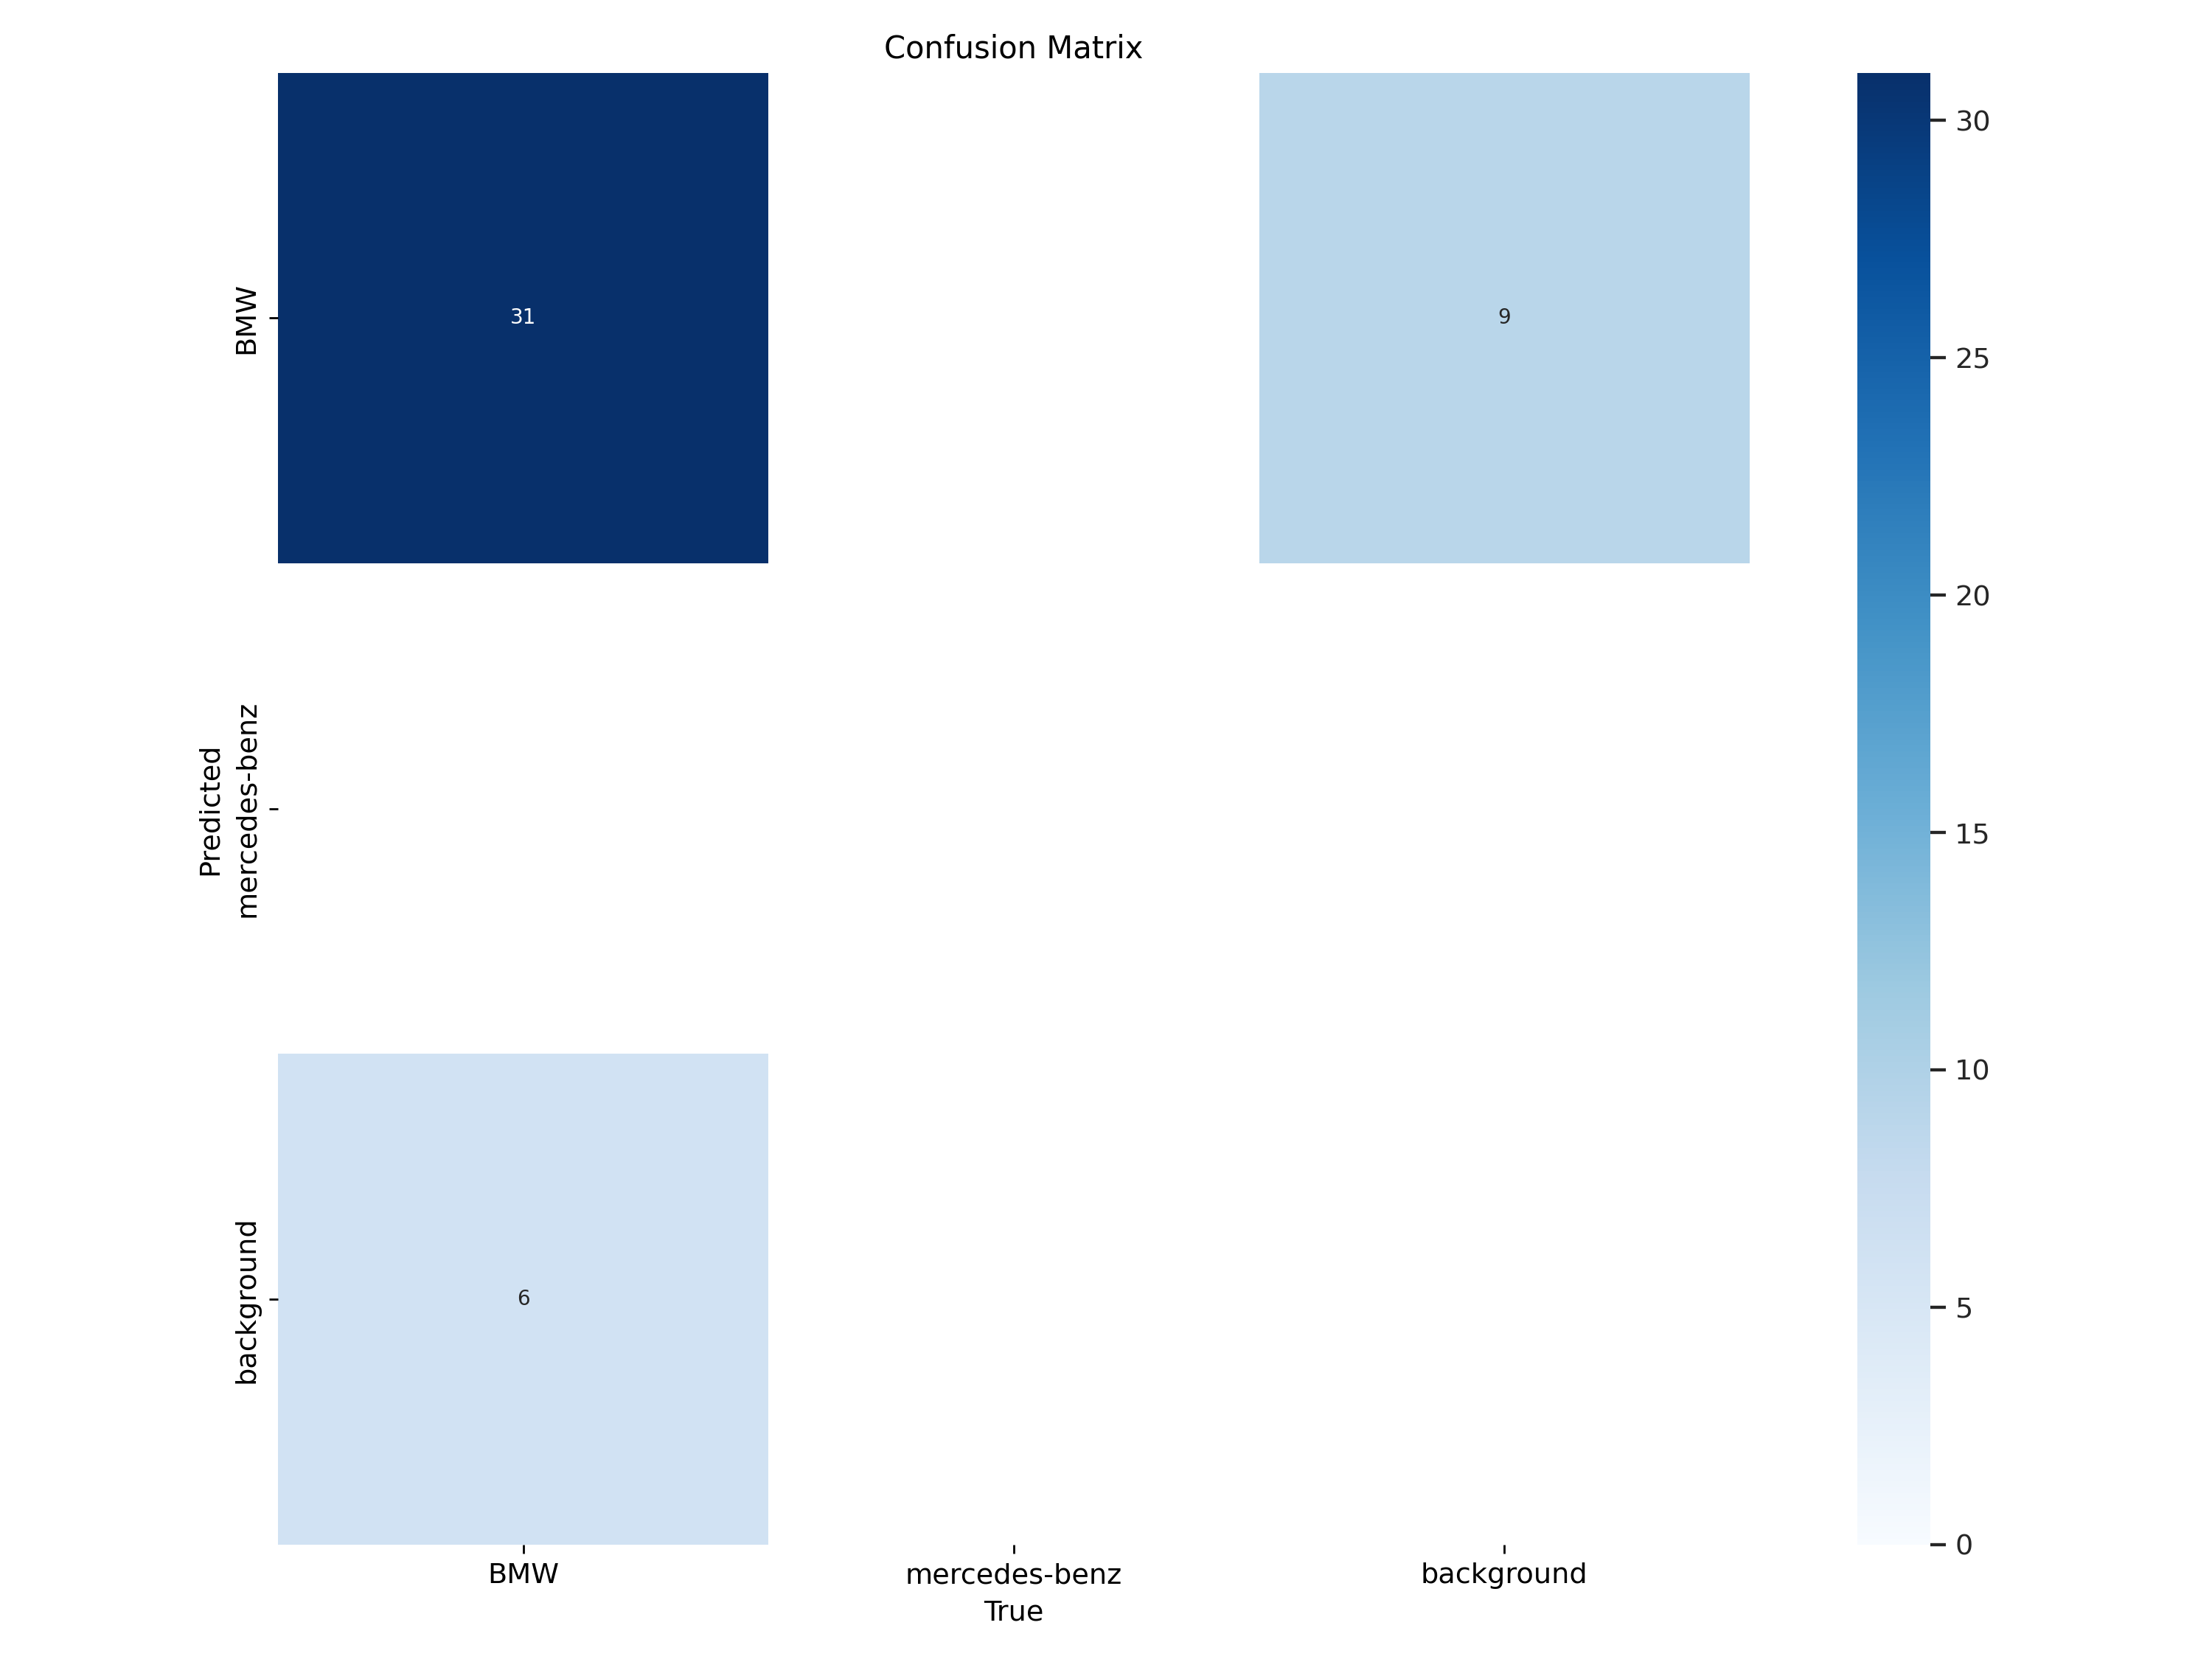

In [22]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

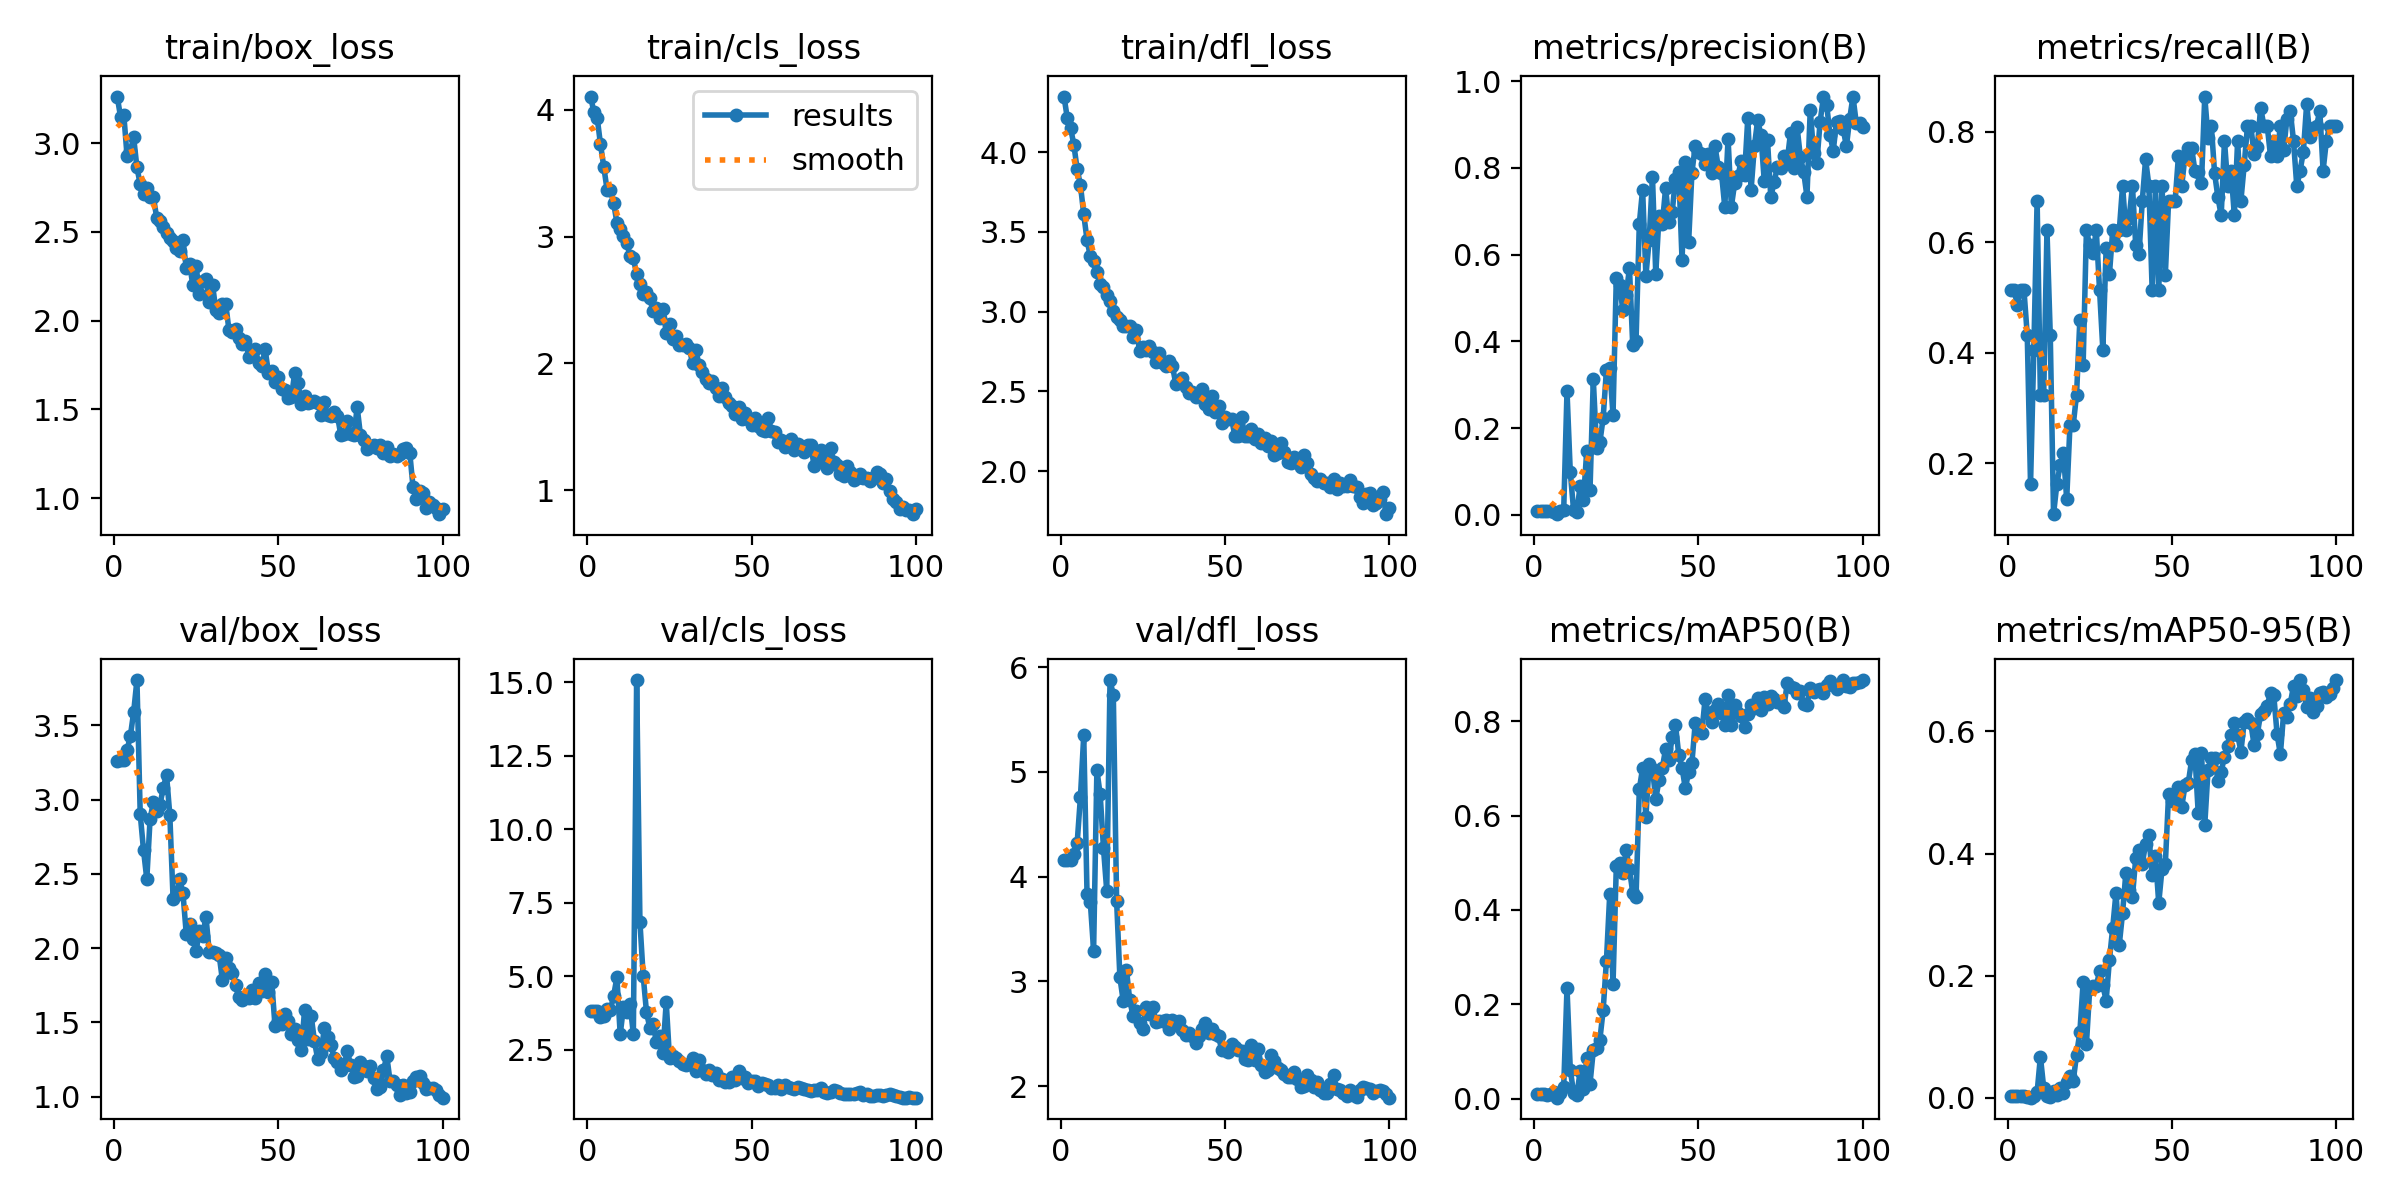

In [23]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [24]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
                                    images_directory_path=f"{dataset_location}/test/images",
                                    annotations_directory_path=f"{dataset_location}/test/labels",
                                    data_yaml_path=f"{data_yaml_path}"
                                  )
ds.classes

['BMW', 'mercedes-benz']

In [25]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets     = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [26]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.6357245724572458
mAP 50 0.9720972097209719
mAP 75 0.6732673267326733


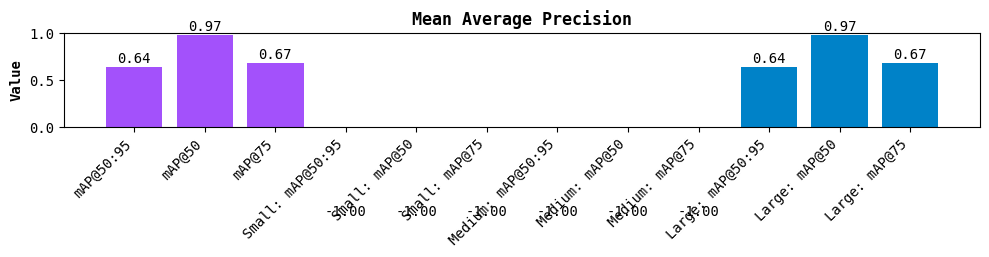

In [27]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [28]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset_location}/test/images",
    annotations_directory_path=f"{dataset_location}/test/labels",
    data_yaml_path=f"{dataset_location}/data.yaml"
)

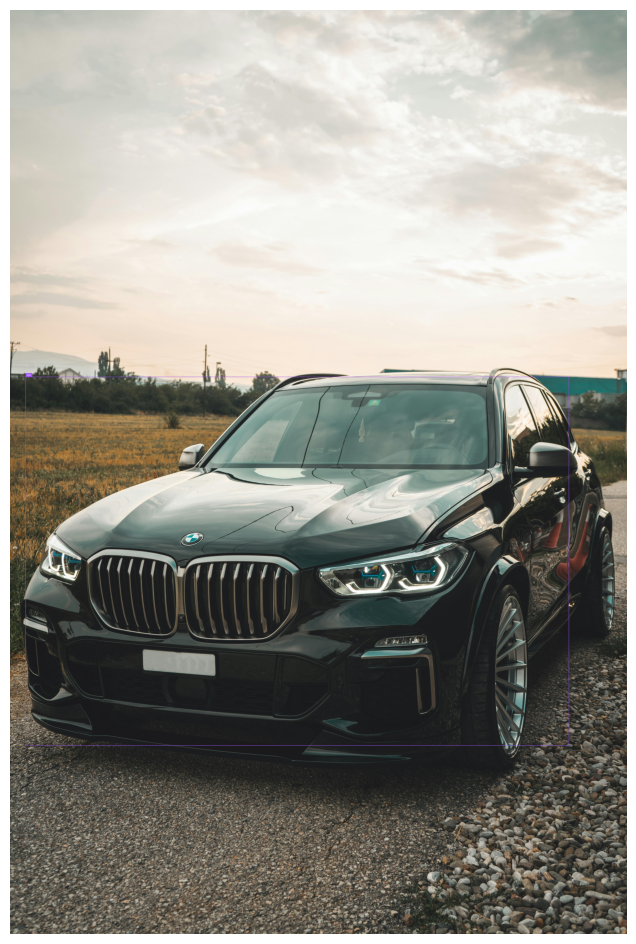

In [29]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

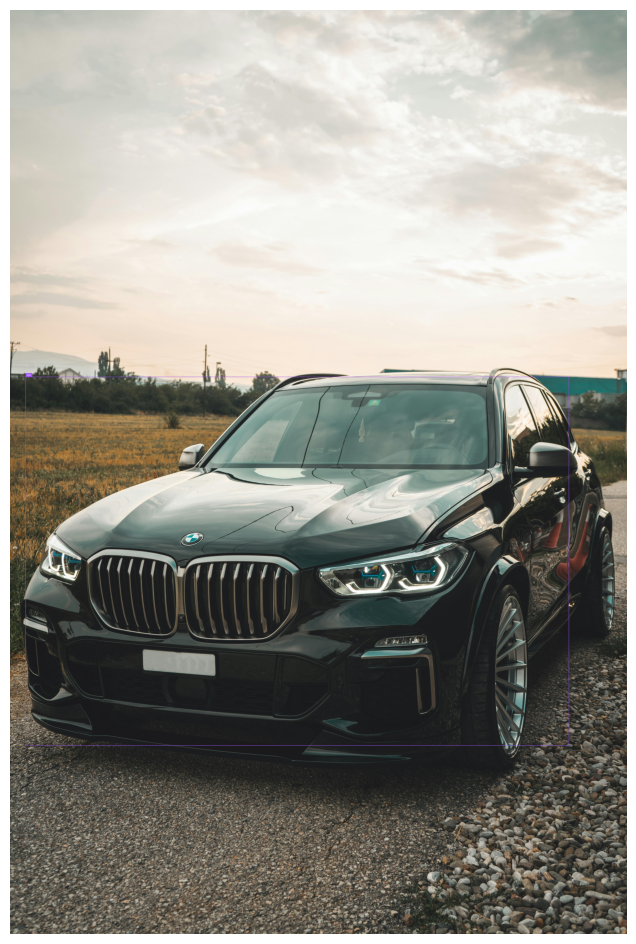

In [30]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

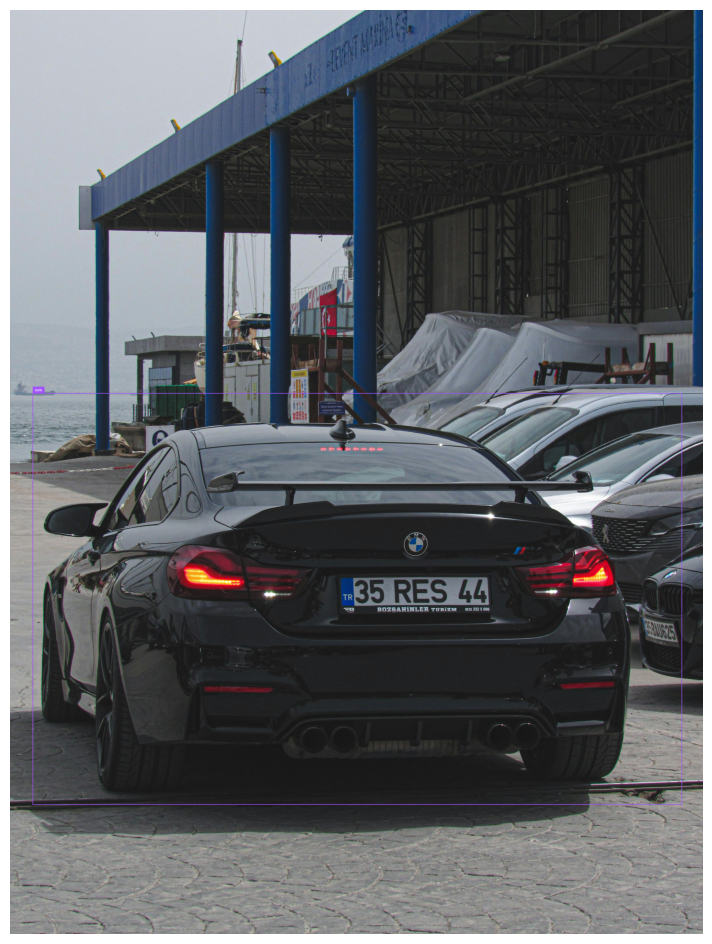

In [31]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

In [ ]:
!zip -r "/content/drive/MyDrive/3CTYOLOv12/yolov12_VGG(VIA)_experiment_results.zip" /content/runs

  adding: content/runs/ (stored 0%)
  adding: content/runs/detect/ (stored 0%)
  adding: content/runs/detect/train/ (stored 0%)
  adding: content/runs/detect/train/args.yaml (deflated 51%)
  adding: content/runs/detect/train/results.png (deflated 7%)
  adding: content/runs/detect/train/train_batch1170.jpg (deflated 8%)
  adding: content/runs/detect/train/P_curve.png (deflated 16%)
  adding: content/runs/detect/train/train_batch1172.jpg (deflated 10%)
  adding: content/runs/detect/train/events.out.tfevents.1753813055.4b70eacd9bf5.451.0 (deflated 91%)
  adding: content/runs/detect/train/confusion_matrix.png (deflated 37%)
  adding: content/runs/detect/train/results.csv (deflated 61%)
  adding: content/runs/detect/train/train_batch0.jpg (deflated 3%)
  adding: content/runs/detect/train/labels_correlogram.jpg (deflated 44%)
  adding: content/runs/detect/train/val_batch0_labels.jpg (deflated 9%)
  adding: content/runs/detect/train/train_batch2.jpg (deflated 3%)
  adding: content/runs/detect

In [33]:
from google.colab import files
uploaded = files.upload()

Saving BMW vs Mercedes.mp4 to BMW vs Mercedes.mp4


In [34]:
from ultralytics import YOLO

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

In [ ]:
import cv2
import supervision as sv

input_path = "/content/BMW vs Mercedes.mp4"
output_path = "output_video.mp4"

cap = cv2.VideoCapture(input_path)

# VideoWriter setup
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or 'avc1'
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame for YOLO
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Inference
    results = model(rgb_frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results).with_nms()

    # Annotate
    annotated = box_annotator.annotate(scene=frame.copy(), detections=detections)
    annotated = label_annotator.annotate(scene=annotated, detections=detections)
    
    # write frame to output video
    out.write(annotated)  

cap.release()
out.release()

In [ ]:
from google.colab import files
files.download("/content/output_video.mp4")